# <center>Household Power Consumption Prediction<center/>

### Description 
This notebook implements a an sequential model from Household Power Consumption Prediction. Model input are measurements of electric power consumption. Data was gathered from one household with a one-minute sampling rate over a period of almost 4 years.

#### Data Set Information:

The dataset contains 2075259 samples/measurements gathered between December 2006 and November 2010 (47 months).<br>
**NOTE**: 
> (global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.

> The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.

**Data Attributes Information:** 

1. date: Date in format dd/mm/yyyy

2. time: time in format hh:mm:ss

3. global_active_power: household global minute-averaged active power (in kilowatt)

4. global_reactive_power: household global minute-averaged reactive power (in kilowatt)

5. voltage: minute-averaged voltage (in volt)

6. global_intensity: household global minute-averaged current intensity (in ampere)

7. sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8. sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9. sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner. <br>

#### Task : 
> Predict the power consumption measurements 

### Import necessary libraries 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas_profiling
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error

### Read data

In [2]:
data_path = "../Dataset/household_power_consumption_data.zip"
df = pd.read_csv(data_path, sep=';',parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True,
                 low_memory=False, na_values=['nan','?'],index_col='dt')

### Exploratory Data Analysis (optional)

In [ ]:
# profile = pandas_profiling.ProfileReport(df)
# profile.to_file("report.html")
# profile

In [ ]:
# df.Global_active_power.resample('D').sum().plot(title='Global_active_power resampled over day for sum')
# #df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day', color='red')
# plt.tight_layout()
# plt.show()

### Preprocess Data
Fill NaN values by average, extract features from timestamps & normalize the data

In [3]:
#fill nan values with column average
for j in range(0,7):
    df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

#Data reshape for LSTM method
def reshape_for_lstm(df, lookback=1):
    l = len(df) - lookback
    X = df
    y = X[lookback:]
    res = []
    
    for i in range(l):
        res.append(X[i:i+lookback])
    return np.array(res), y

#Extract features from timestamp 
def features_from_timestamp(t):
    h = t.hour
    idx = np.searchsorted(list(range(3,25,3)),h,side='right')
    interval = np.arange(3,25,3)[idx]
    if  interval == 24 : interval = 0
    month = t.month
    season = (month in [11,12,1,2,3]) * 1 # 0: summer, 1:  winter
    return [h,t.day ,t.dayofweek, month , interval , season]

col = ["hour","day" ,"dayofweek", "month" , "interval" , "season"]

In [4]:
#Generate aditional features from timestamp then append to exixting data
additional_featues = pd.DataFrame(data = [features_from_timestamp(i) for i in df.index ],columns=col).set_index(df.index)
data = df.merge(additional_featues,on="dt")
data.sort_index(inplace=True) #make sure data is sorted by date
data.tail()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day,dayofweek,month,interval,season
dt,,,,,,,,,,,,,
2010-11-26 20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0,20,26,4,11,21,1
2010-11-26 20:59:00,0.944,0.0,240.00,4.0,0.0,0.0,0.0,20,26,4,11,21,1
2010-11-26 21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0,21,26,4,11,0,1
2010-11-26 21:01:00,0.934,0.0,239.70,3.8,0.0,0.0,0.0,21,26,4,11,0,1
2010-11-26 21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0,21,26,4,11,0,1


In [5]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day,dayofweek,month,interval,season
dt,,,,,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,17,16,5,12,18,1
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,17,16,5,12,18,1
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,17,16,5,12,18,1
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,17,16,5,12,18,1
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,17,16,5,12,18,1


In [37]:
#Optional : Data can be grouped using timestamps by specific time i.e 1hr, 3hrs
# grouped_2h = df.groupby(pd.Grouper(freq='2h', base=0, label='right')).mean()
list(data.columns)

['Global_active_power',
 'Global_reactive_power',
 'Voltage',
 'Global_intensity',
 'Sub_metering_1',
 'Sub_metering_2',
 'Sub_metering_3',
 'hour',
 'day',
 'dayofweek',
 'month',
 'interval',
 'season']

In [7]:
#Split data to train and test
test = data['2010-10-26':] #one month for testing
train = data[:'2010-10-26'] 

In [8]:
#Standardize the data
scaler = StandardScaler()
train = scaler.fit_transform(train.values)
test = scaler.transform(test.values)

In [9]:
#Prepare data for LSTM input
lookback = 10 #look back 3hrs
Xtrain, ytrain = reshape_for_lstm(train,lookback)
Xtest, ytest = reshape_for_lstm(test,lookback)

In [10]:
Xtrain.shape

(2030786, 10, 13)

### Define LSTM model

In [11]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM, Dropout, Dense

Using TensorFlow backend.


In [16]:
model = Sequential()
model.add(LSTM(10, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
# model.add(Dropout(0.2))
model.add(Dense(ytrain.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')

### Train Model

In [17]:
history = model.fit(Xtrain, ytrain, epochs=20, batch_size=7000, validation_split=0.1,
                     verbose=1, shuffle=False)


Train on 1827707 samples, validate on 203079 samples
Epoch 1/20
1827707/1827707 [==============================] - 24s 13us/step - loss: 0.8663 - val_loss: 0.4645
Epoch 2/20
1827707/1827707 [==============================] - 21s 12us/step - loss: 0.5468 - val_loss: 0.3327
Epoch 3/20
1827707/1827707 [==============================] - 21s 12us/step - loss: 0.4112 - val_loss: 0.2652
Epoch 4/20
1827707/1827707 [==============================] - 24s 13us/step - loss: 0.3311 - val_loss: 0.2136
Epoch 5/20
1827707/1827707 [==============================] - 23s 13us/step - loss: 0.2507 - val_loss: 0.1572
Epoch 6/20
1827707/1827707 [==============================] - 21s 12us/step - loss: 0.1885 - val_loss: 0.1195
Epoch 7/20
1827707/1827707 [==============================] - 23s 12us/step - loss: 0.1542 - val_loss: 0.0990
Epoch 8/20
1827707/1827707 [==============================] - 34s 18us/step - loss: 0.1356 - val_loss: 0.0880
Epoch 9/20
1827707/1827707 [==============================] - 30s 1

### Plot Train loss

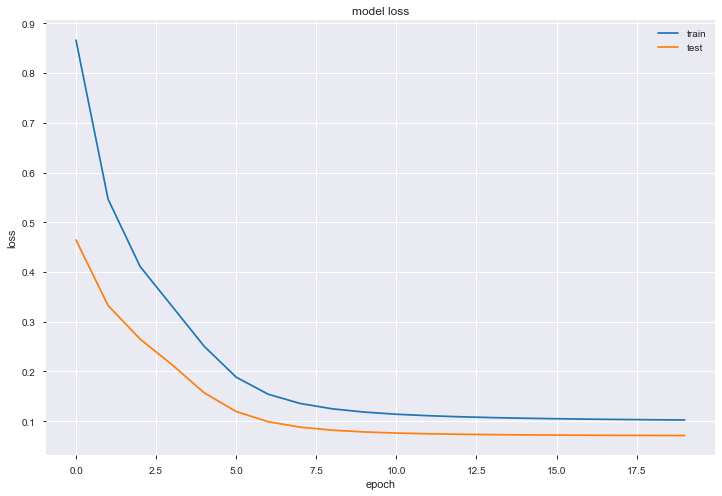

In [35]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
plt.plot(history.epoch,history.history['loss'])
plt.plot(history.epoch,history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Evaluate model Performance 

In [33]:
yhat = model.predict(Xtest)
mse = mean_squared_error(yhat,ytest)

In [34]:
print('MSE : {}'.format(mse))

MSE : 0.16564021608753038
